In [1]:
import mne
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import numpy as np
from colour import Color
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet
from matplotlib.gridspec import GridSpec
import pyprep
from scipy import stats
from scipy.stats import zscore
import pandas as pd
from statannot import add_stat_annotation
import matplotlib.pyplot as plt
from mne_connectivity import spectral_connectivity_epochs

plt.rcParams["font.family"] = "Arial"
mne.__version__

'1.3.1'

In [2]:
n_part = 29 # number of participants

In [3]:
def get_stat(var): # get median and 25th, 75th percentiles
    print(f'{np.median(var):.2f} [{np.percentile(var, 25):.2f}-{np.percentile(var, 75):.2f}]')

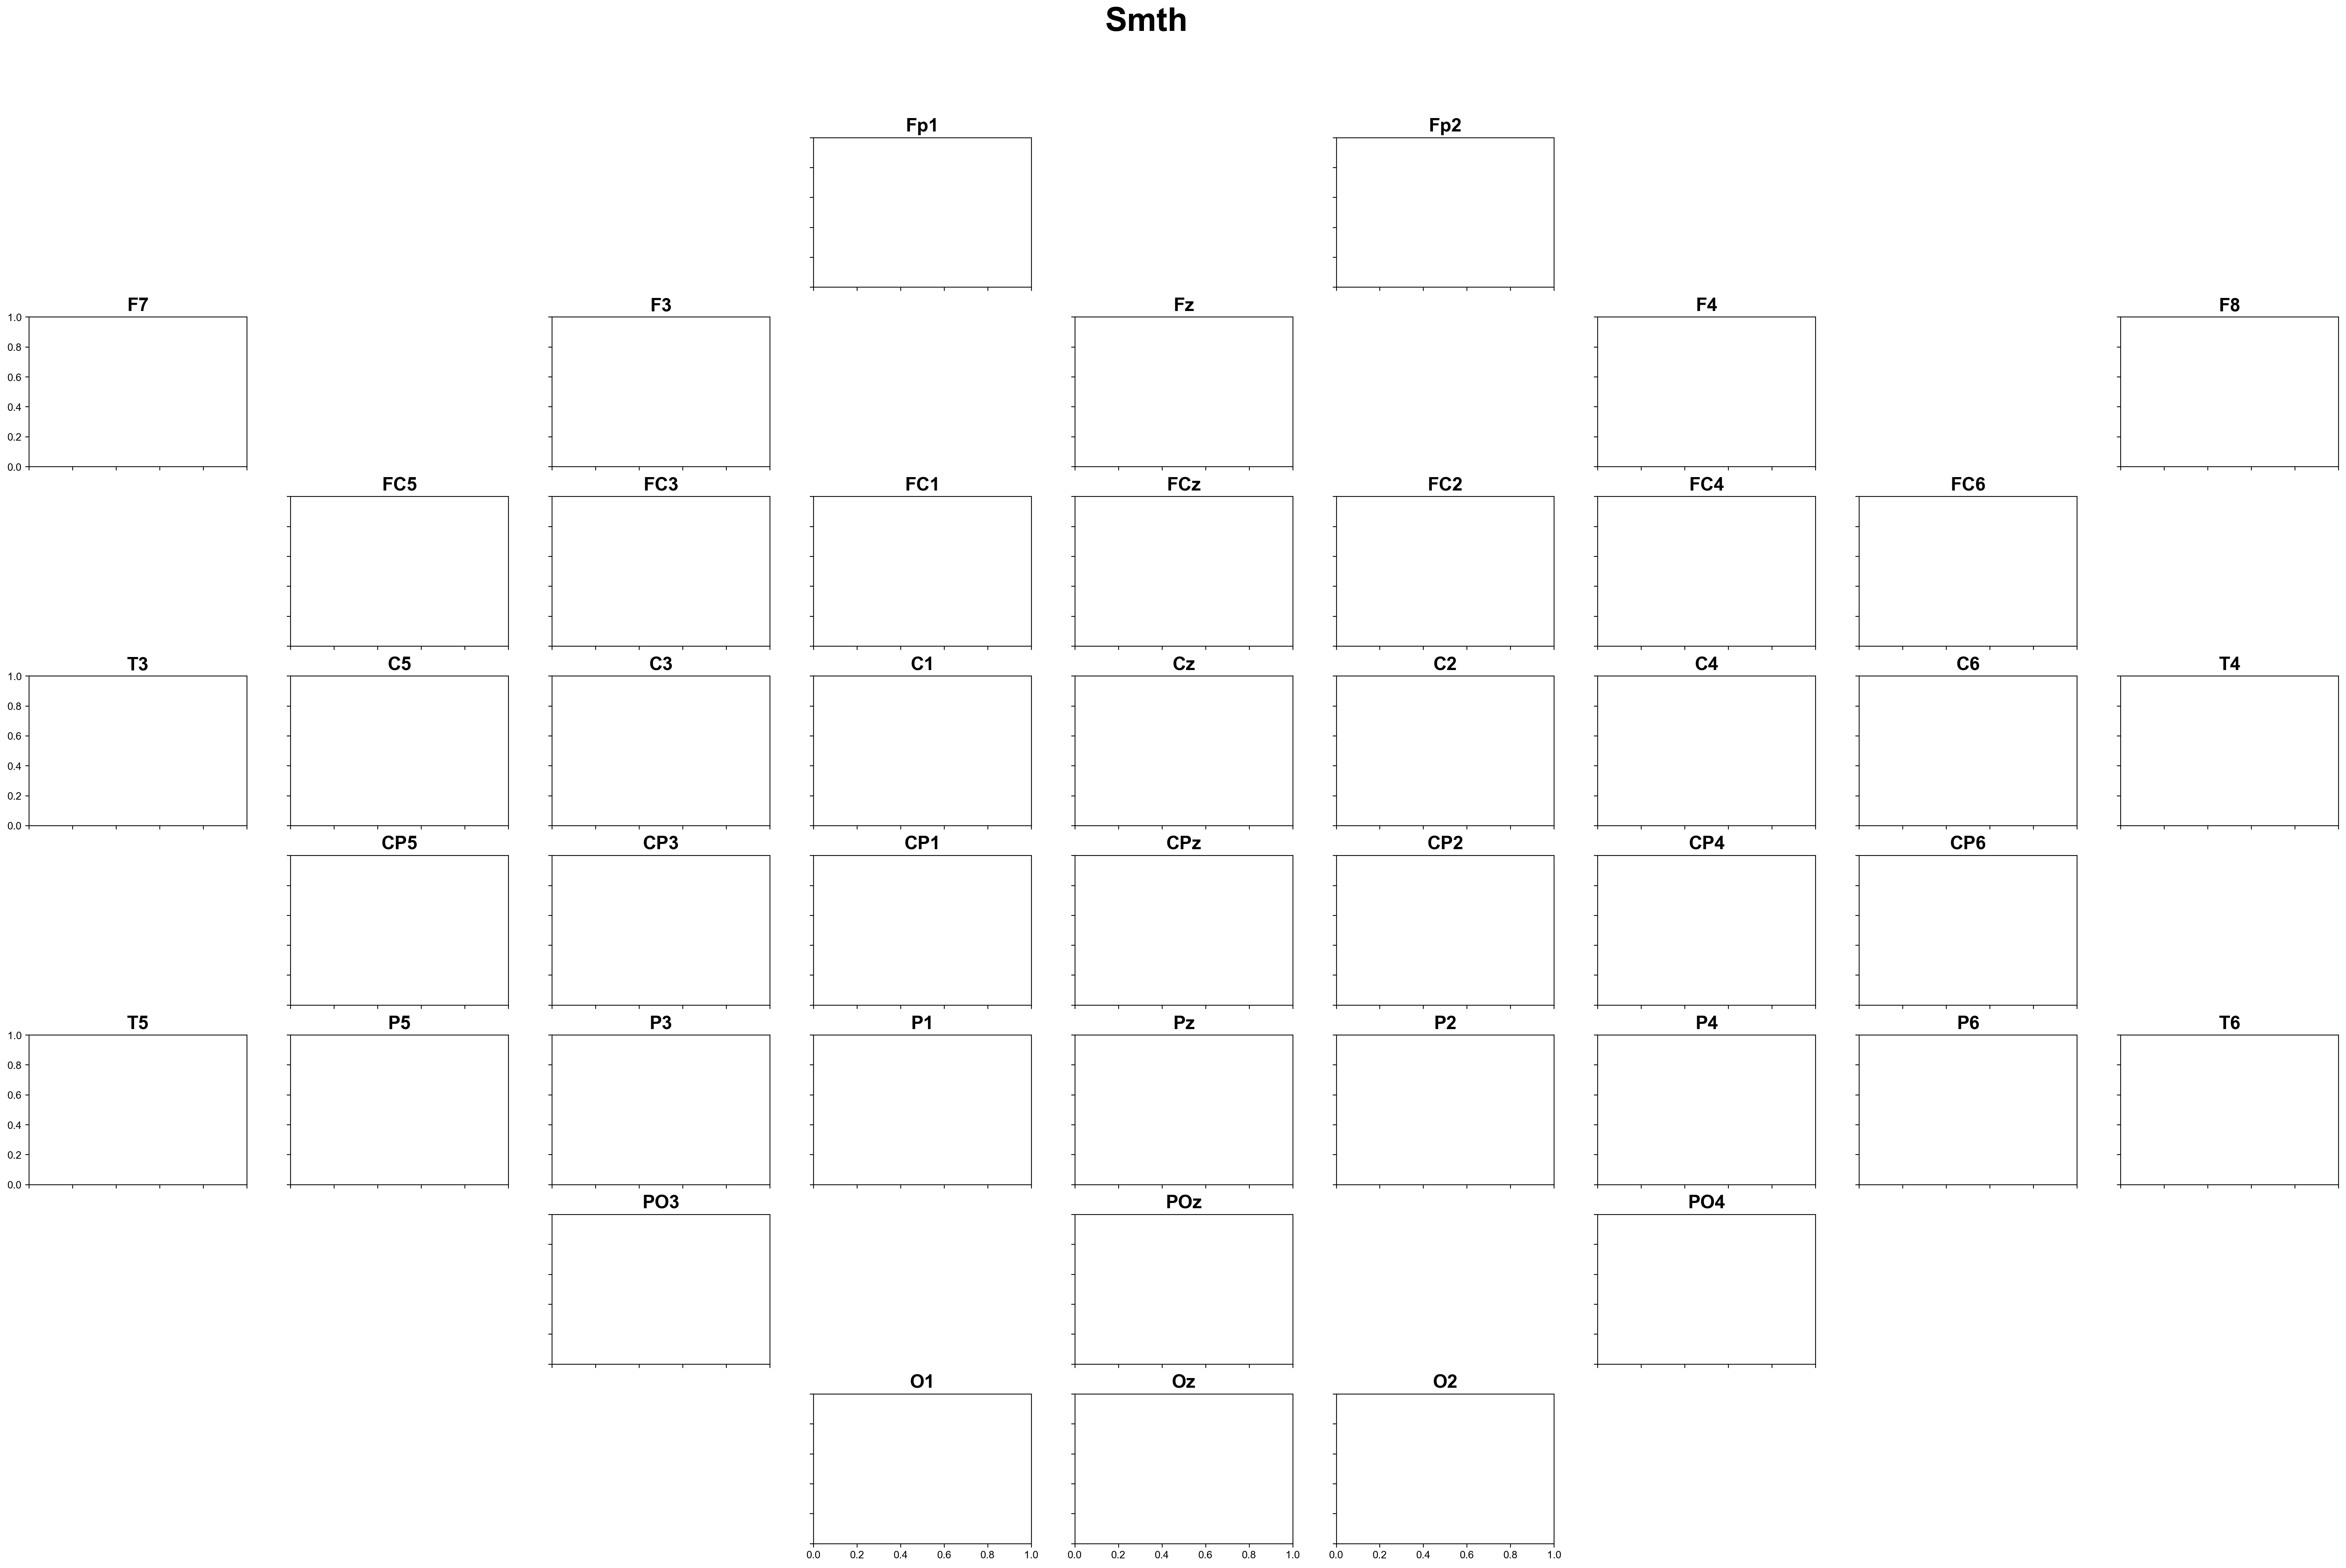

In [4]:
fs = 500
electrodes = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'T3', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T4', 'TP9', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP10', 'T5', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'T6', 'PO3', 'POz', 'PO4', 'O1', 'Oz', 'O2']

dict_rows = {
    'Fp':0,
    'F':1,
    'FC':2,
    'T':-1,
    'TP':-1,
    'C':3,
    'CP':4,
    'P':5,
    'PO':6,
    'O':7,
}

dict_cols = {
    '9':-1,
    '7':0,
    '5':1,
    '3':2,
    '1':3,
    'z':4,
    '2':5,
    '4':6,
    '6':7,
    '8':8, 
    '10':-1
}

cols_seq = [dict_cols[re.split('(\d+)', i)[1]] if 'z' not in i else dict_cols[i[-1]] for i in electrodes]
rows_seq = [dict_rows[re.split('(\d+)', i)[0]] if 'z' not in i else dict_rows[i[:-1]] for i in electrodes]

cols_seq[electrodes.index('T3')] = 0
rows_seq[electrodes.index('T3')] = 3
cols_seq[electrodes.index('T4')] = 8
rows_seq[electrodes.index('T4')] = 3

cols_seq[electrodes.index('T5')] = 0
rows_seq[electrodes.index('T5')] = 5
cols_seq[electrodes.index('T6')] = 8
rows_seq[electrodes.index('T6')] = 5

nrows = max(rows_seq)+1
ncols = max(cols_seq)+1

figure, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(40, 25), sharex=True, sharey=True, dpi=200)

for e in range(len(electrodes)):
    if electrodes[e] in ['TP9', 'TP10']:
        continue
    axes[rows_seq[e]][cols_seq[e]].set_title(electrodes[e], fontsize=18, fontweight='bold')
    
pairs = [str(rows_seq[i])+str(cols_seq[i]) for i in range(len(electrodes))]
    
for row in range(nrows):
    for col in range(ncols):
        if str(row) + str(col) not in pairs:
            axes[row][col].set_axis_off()

# figure.subplots_adjust(right=0.8)
# cbar_ax = figure.add_axes([0.83, 0.4, 0.01, 0.3])
# cbar = figure.colorbar(cp, cax=cbar_ax)
# cbar.ax.set_title(mode, fontsize=18)
            
plt.suptitle('Smth', fontsize=32, y=0.95, fontweight='bold')
plt.show()

# ERP

In [5]:
rest_erp = np.load('preprocesed_data/erp/rest.npy')
im_erp = np.load('preprocesed_data/erp/imagery.npy')

In [6]:
es_p100_left = [
    electrodes.index(i) for i in ['P1', 'CP3', 'P5', 'P3']
]
es_p100_right = [
    electrodes.index(i) for i in ['P2', 'CP4', 'P6','P4']
]
ts_p100 = slice(295, 310)



es_p200_left = [
    electrodes.index(i) for i in ['F3', 'FC1', 'FC3']
]
es_p200_right = [
    electrodes.index(i) for i in ['F4', 'FC2', 'FC4']
]
es_p200_both = [
    electrodes.index(i) for i in ['F3', 'FC1', 'FC3', 'FCz', 'F4', 'FC2', 'FC4']
]
ts_p200 = slice(355, 370)



es_p300_left = [
    electrodes.index(i) for i in ['C5', 'CP5']
]
es_p300_right = [
    electrodes.index(i) for i in ['C6', 'CP6'] 
]
ts_p300 = slice(395, 410)

In [7]:
info = mne.create_info(electrodes, 500, ch_types='eeg', verbose=None)
montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC3, FC1, FCz, FC2, FC4, FC6, ...
 chs: 47 EEG
 custom_ref_applied: False
 dig: 50 items (3 Cardinal, 47 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 47
 projs: []
 sfreq: 500.0 Hz
>

Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated


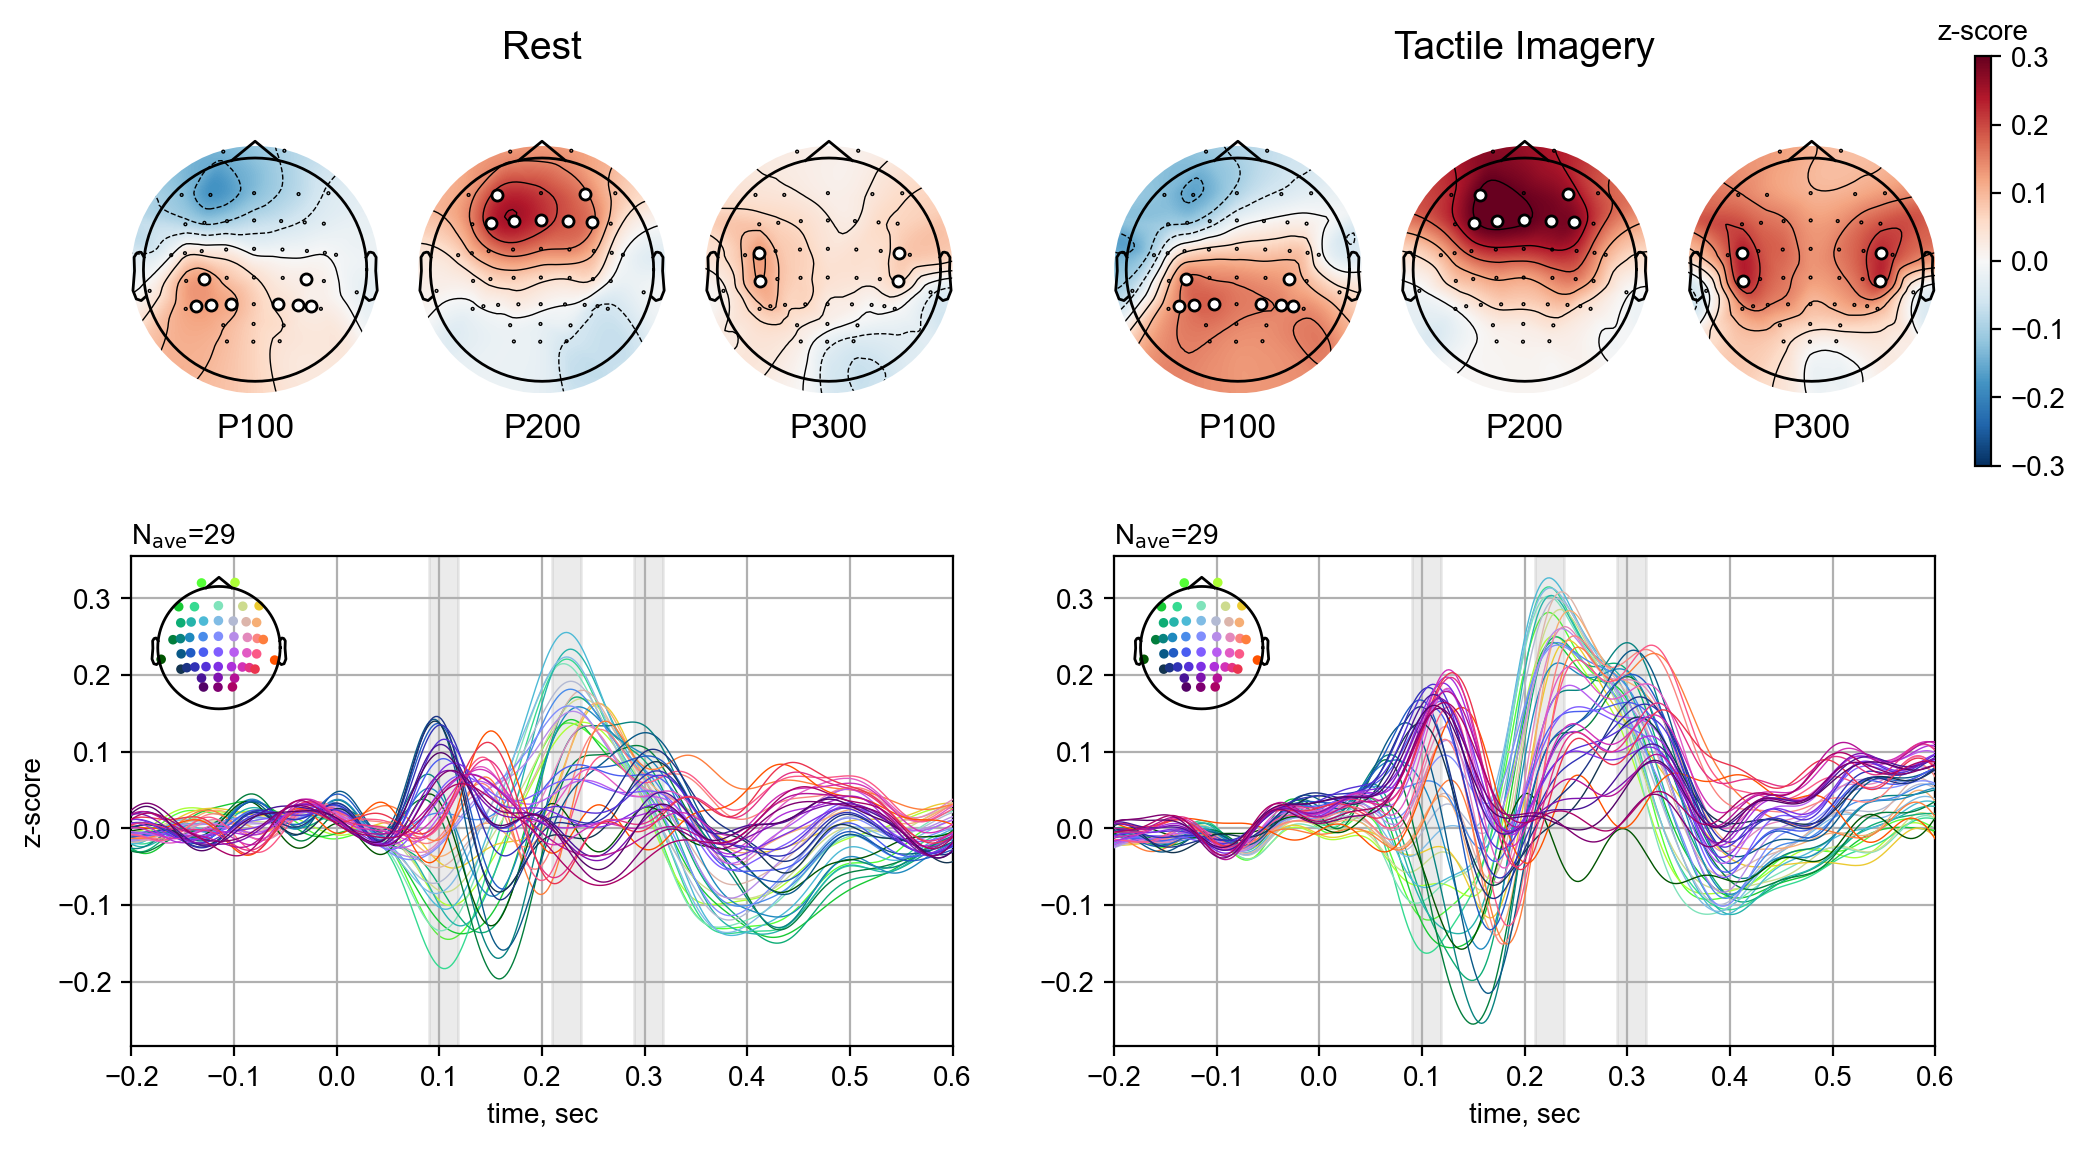

In [8]:


fig = plt.figure(dpi=200, figsize=(12, 6))
gs = GridSpec(nrows=2, ncols=8, figure=fig, width_ratios=[0.15]*3 + [0.05] + [0.15]*3 + [0.01], height_ratios=[0.5, 0.6])

locs = [
    es_p100_left+es_p100_right,
    es_p200_both,
    es_p300_left+es_p300_right
]

for i, eps in enumerate([rest_erp, im_erp]):
    for j, times in enumerate([ts_p100, ts_p200, ts_p300]):
        ax = fig.add_subplot(gs[0, i*3+j+1*i])
        im, cm = mne.viz.plot_topomap(np.mean(eps[:, :, times], axis=(0,-1)), info, axes=ax,
                                      vlim=(-0.3, 0.3), show=False, mask=np.array([True if e in locs[j] else False for e in range(len(electrodes))]))

        ax.set_xlabel(['P100', 'P200', 'P300'][j], fontsize=12)
        
        if (i, j) == (0, 1):
            ax.set_title('Rest', fontsize=14, y=1.2)
            
        if (i, j) == (1, 1):
            ax.set_title('Tactile Imagery', fontsize=14, y=1.2)
        
ax = fig.add_subplot(gs[0, -1])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.set_title('z-score', fontsize=10)

# with plt.style.context(('seaborn-darkgrid')):

axes = [fig.add_subplot(gs[1, :3]), fig.add_subplot(gs[1, 4:-1])]


for i, eps in enumerate([rest_erp, im_erp]):

    eps_erp = mne.EpochsArray(eps/1e6, info, tmin=-0.5)
    eps_erp.average().plot(axes=axes[i], show=False)

    axes[i].grid()

    axes[i].set_xlim(-0.2, 0.6)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title('')

for i in range(2):
    for j, times in enumerate([ts_p100, ts_p200, ts_p300]):
        axes[i].axvspan(eps_erp.times[times][0], eps_erp.times[times][-1], color='tab:gray', alpha=0.15)

axes[0].set_ylabel('z-score')
axes[0].set_xlabel('time, sec')
axes[1].set_xlabel('time, sec')

axes[0].sharey(axes[1])

# axes[0].grid(color='white', linewidth=0.5)
# axes[1].grid(color='white', linewidth=0.5)

plt.savefig('figs/erps.jpg', bbox_inches='tight')
plt.show()

In [9]:
# for part_rest_erp, part_im_erp in zip(rest_erp, im_erp):
    
#     fig = plt.figure(dpi=200, figsize=(12, 6))
#     gs = GridSpec(nrows=2, ncols=8, figure=fig, width_ratios=[0.15]*3 + [0.05] + [0.15]*3 + [0.01], height_ratios=[0.5, 0.6])

#     locs = [
#         es_p100_left+es_p100_right,
#         es_p200_left+es_p200_right,
#         es_p300_left+es_p300_right
#     ]

#     for i, eps in enumerate([part_rest_erp, part_im_erp]):
#         for j, times in enumerate([ts_p100, ts_p200, ts_p300]):
#             ax = fig.add_subplot(gs[0, i*3+j+1*i])
#             im, cm = mne.viz.plot_topomap(np.mean(eps[:, times], axis=(-1)), info, axes=ax,
#                                           vlim=(-0.3, 0.3), show=False, mask=np.array([True if e in locs[j] else False for e in range(len(electrodes))]))

#             ax.set_xlabel(['P100', 'P200', 'P300'][j], fontsize=12)

#             if (i, j) == (0, 1):
#                 ax.set_title('Rest', fontsize=14, y=1.2)

#             if (i, j) == (1, 1):
#                 ax.set_title('Tactile Imagery', fontsize=14, y=1.2)

#     ax = fig.add_subplot(gs[0, -1])
#     cbar = plt.colorbar(im, cax=ax)
#     cbar.ax.set_title('z-score', fontsize=10)

#     # with plt.style.context(('seaborn-darkgrid')):

#     axes = [fig.add_subplot(gs[1, :3]), fig.add_subplot(gs[1, 4:-1])]


#     for i, eps in enumerate([part_rest_erp, part_im_erp]):

#         eps_erp = mne.EpochsArray(eps[None]/1e6, info, tmin=-0.5)
#         eps_erp.average().plot(axes=axes[i], show=False)

#         axes[i].grid()

#         axes[i].set_xlim(-0.2, 0.6)
#         axes[i].set_xlabel('')
#         axes[i].set_ylabel('')
#         axes[i].set_title('')

#     for i in range(2):
#         for j, times in enumerate([ts_p100, ts_p200, ts_p300]):
#             axes[i].axvspan(eps_erp.times[times][0], eps_erp.times[times][-1], color='tab:gray', alpha=0.15)

#     axes[0].set_ylabel('z-score')
#     axes[0].set_xlabel('time, sec')
#     axes[1].set_xlabel('time, sec')

#     axes[0].sharey(axes[1])

#     # axes[0].grid(color='white', linewidth=0.5)
#     # axes[1].grid(color='white', linewidth=0.5)

# #     plt.savefig('figs/erps.jpg', bbox_inches='tight')
#     plt.show()

In [10]:
lats_p100_left = [0, 0]
lats_p200_left = [0, 0]
lats_p300_left = [0, 0]

lats_p100_right = [0, 0]
lats_p200_right = [0, 0]
lats_p300_right = [0, 0]

latencies = [
    [lats_p100_left, lats_p200_left, lats_p300_left],
    [lats_p100_right, lats_p200_right, lats_p300_right]
]

time_slices = [slice(275, 325), slice(325, 375), slice(400, 425)]

for i, locs in enumerate([[es_p100_left, es_p100_right], [es_p200_left, es_p200_right], [es_p300_left, es_p300_right]]):
    
    for j, data in enumerate([rest_erp, im_erp]):
        
        idx = np.argmax(data[:, locs[0]].mean(axis=(0, 1))[time_slices[i]])
#         l_left = np.linspace(-0.5, 1, 751)[time_slices[i]][0]+idx/500
        l_left = time_slices[i].start + idx
        
        idx = np.argmax(data[:, locs[1]].mean(axis=(0, 1))[time_slices[i]])
#         l_right = np.linspace(-0.5, 1, 751)[time_slices[i]][0]+idx/500
        l_right = time_slices[i].start + idx
        
        latencies[0][i][j] = l_left
        latencies[1][i][j] = l_right

In [11]:
# latencies_left = np.array([
#     np.mean(lats_p100_left),
#     np.mean(lats_p200_left),
#     np.mean(lats_p300_left)
# ]).round(3)

# latencies_right = np.array([
#     np.mean(lats_p100_right),
#     np.mean(lats_p200_right),
#     np.mean(lats_p300_right)
# ]).round(3)

latencies_left = np.array([
    lats_p100_left,
    lats_p200_left,
    lats_p300_left
]).round(3)

latencies_right = np.array([
    lats_p100_right,
    lats_p200_right,
    lats_p300_right
]).round(3)

latencies_left, latencies_right

(array([[300, 302],
        [363, 362],
        [400, 401]], dtype=int64),
 array([[320, 313],
        [368, 367],
        [416, 410]], dtype=int64))

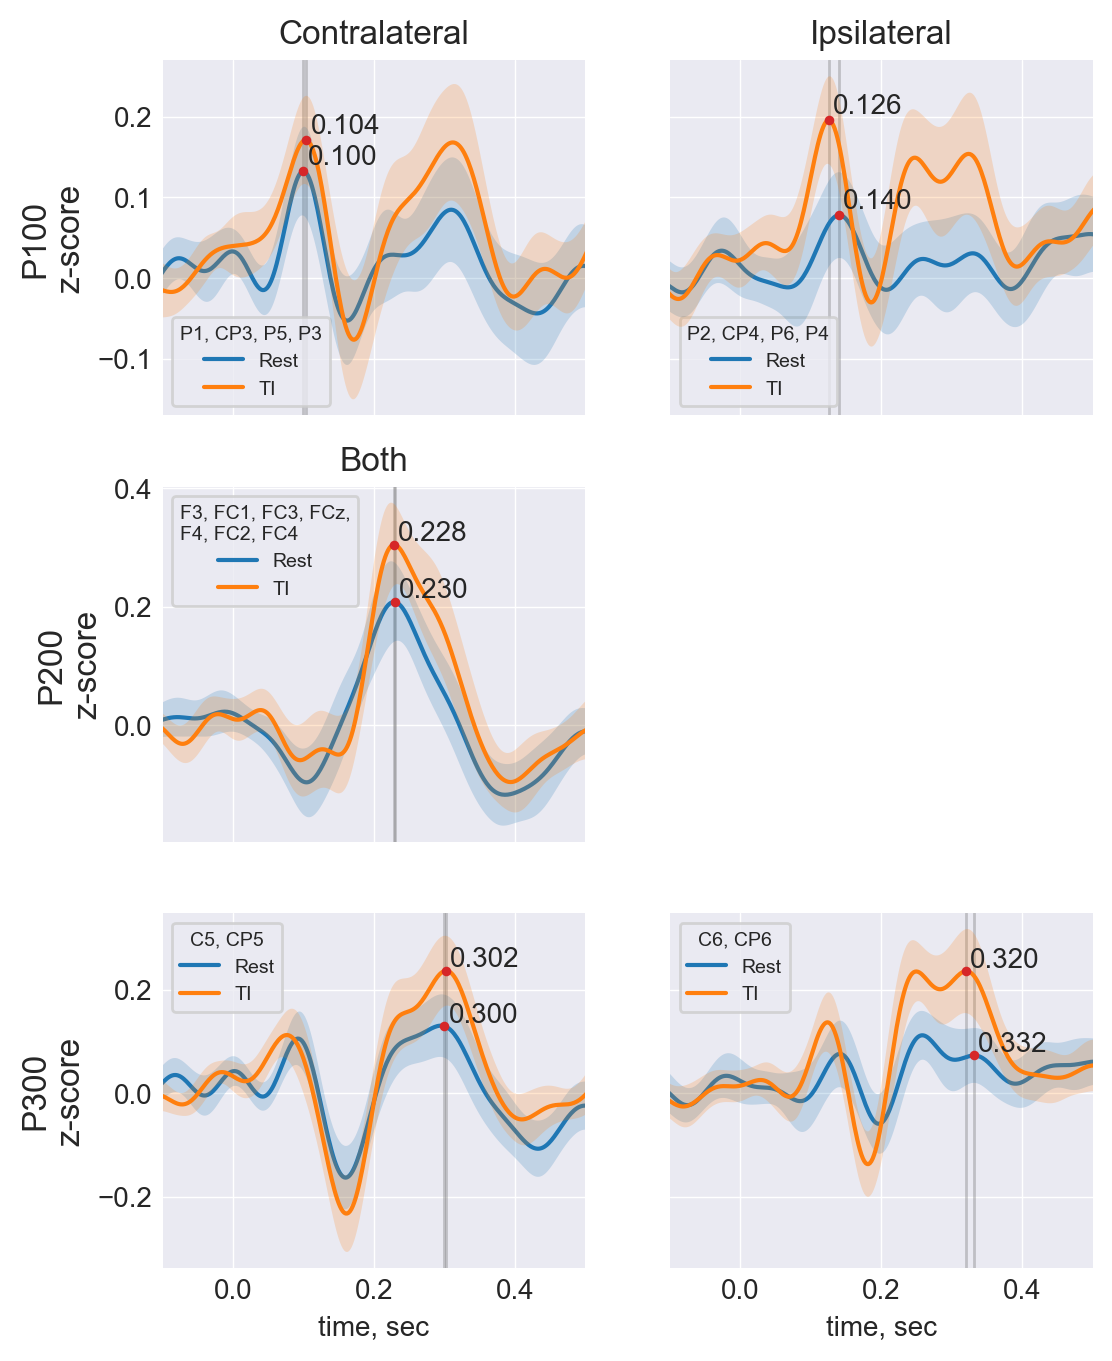

In [12]:
with plt.style.context(('seaborn-darkgrid')):

    figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(6, 8), dpi=200, sharey='row', sharex=True)

    row_names = ['P100', 'P200', 'P300']
    col_names = ['Contralateral', 'Ipsilateral']
    times = [ts_p100, ts_p200, ts_p300]

    for i in range(2):
        axes[0][i].set_title(col_names[i])

    for i in range(3):
        axes[i][0].set_ylabel(row_names[i]+'\nz-score', fontsize=12)
    #     axes[i][1].set_ylabel('z-score')

    for i, locs in enumerate([[es_p100_left, es_p100_right], [es_p200_both, es_p200_both], [es_p300_left, es_p300_right]]):
        for j, data in enumerate([rest_erp, im_erp]):
            
            if (i == 1):
                
                time1 = np.linspace(-0.5, 1, 751)[int((latencies_left[i][j]+latencies_right[i][j])/2)]
                amp1 = data[:, locs[0]].mean(axis=(0, 1))[int((latencies_left[i][j]+latencies_right[i][j])/2)]
                axes[i][0].scatter(time1, amp1, color='tab:red', s=6, zorder=1000000)

                axes[i][0].text(time1+0.006, amp1+0.008, f'{time1:.3f}', fontsize=10, zorder=10000000)

                axes[i][0].axvline(time1, color='tab:gray', alpha=0.4, linewidth=1, zorder=1)

                axes[i][0].plot(np.linspace(-0.5, 1, 751), data[:, locs[0]].mean(axis=(0, 1)), label=['Rest', 'TI'][j], zorder=10) #'left: '+', '.join([electrodes[i] for i in locs[0]]))

                ci = 1.96 * np.std(data[:, locs[0]].mean(axis=(1)), axis=0)/np.sqrt(len(data)) # confidence interval
                axes[i][0].fill_between(np.linspace(-0.5, 1, 751), (data[:, locs[0]].mean(axis=(0, 1))-ci), (data[:, locs[0]].mean(axis=(0, 1))+ci), alpha=.2, zorder=10)
        
                legend = axes[i][0].legend(loc=2, title='F3, FC1, FC3, FCz,\nF4, FC2, FC4', fontsize=7, frameon=True)
                legend.get_title().set_fontsize('7')
                axes[i][0].set_axisbelow(True)
                axes[i][0].grid(color='white', linewidth=0.5, zorder=0)
                axes[i][0].set_xlim(-0.1, 0.5)
                
            else:
            
                time1 = np.linspace(-0.5, 1, 751)[latencies_left[i][j]]
                amp1 = data[:, locs[0]].mean(axis=(0, 1))[latencies_left[i][j]]
                axes[i][0].scatter(time1, amp1, color='tab:red', s=6, zorder=1000000)

                time2 = np.linspace(-0.5, 1, 751)[latencies_right[i][j]]
                amp2 = data[:, locs[1]].mean(axis=(0, 1))[latencies_right[i][j]]
                axes[i][1].scatter(time2, amp2, color='tab:red', s=6, zorder=10000000)

                axes[i][0].text(time1+0.006, amp1+0.008, f'{time1:.3f}', fontsize=10, zorder=10000000)
                axes[i][1].text(time2+0.006, amp2+0.008, f'{time2:.3f}', fontsize=10, zorder=10000000)

                axes[i][0].axvline(time1, color='tab:gray', alpha=0.4, linewidth=1, zorder=1)
                axes[i][1].axvline(time2, color='tab:gray', alpha=0.4, linewidth=1, zorder=1)

                axes[i][0].plot(np.linspace(-0.5, 1, 751), data[:, locs[0]].mean(axis=(0, 1)), label=['Rest', 'TI'][j], zorder=10) #'left: '+', '.join([electrodes[i] for i in locs[0]]))
                axes[i][1].plot(np.linspace(-0.5, 1, 751), data[:, locs[1]].mean(axis=(0, 1)), label=['Rest', 'TI'][j], zorder=11)

                ci = 1.96 * np.std(data[:, locs[0]].mean(axis=(1)), axis=0)/np.sqrt(len(data)) # confidence interval
                axes[i][0].fill_between(np.linspace(-0.5, 1, 751), (data[:, locs[0]].mean(axis=(0, 1))-ci), (data[:, locs[0]].mean(axis=(0, 1))+ci), alpha=.2, zorder=10)

                ci = 1.96 * np.std(data[:, locs[1]].mean(axis=(1)), axis=0)/np.sqrt(len(data)) # confidence interval
                axes[i][1].fill_between(np.linspace(-0.5, 1, 751), (data[:, locs[1]].mean(axis=(0, 1))-ci), (data[:, locs[1]].mean(axis=(0, 1))+ci), alpha=.2, zorder=11)

#             axes[i][j].axvspan(eps_erp.times[times[i]][0], eps_erp.times[times[i]][-1], color='tab:gray', alpha=0.3)
            

                if i == 0:
                    legend = axes[i][0].legend(loc=3, title = ', '.join([electrodes[i] for i in locs[0]]), fontsize=7, frameon=True)
                    legend.get_title().set_fontsize('7')
                    legend = axes[i][1].legend(loc=3, title = ', '.join([electrodes[i] for i in locs[1]]), fontsize=7, frameon=True)
                    legend.get_title().set_fontsize('7')
                elif i in [1, 2]:
                    legend = axes[i][0].legend(loc=2, title = ', '.join([electrodes[i] for i in locs[0]]), fontsize=7, frameon=True)
                    legend.get_title().set_fontsize('7')
                    legend = axes[i][1].legend(loc=2, title = ', '.join([electrodes[i] for i in locs[1]]), fontsize=7, frameon=True)
                    legend.get_title().set_fontsize('7')
                axes[i][j].set_axisbelow(True)
                axes[i][j].grid(color='white', linewidth=0.5, zorder=0)
                axes[i][j].set_xlim(-0.1, 0.5)

    axes[-1][0].set_xlabel('time, sec')   
    axes[-1][1].set_xlabel('time, sec')

    axes[1][0].set_title('Both')
    axes[1][1].set_axis_off()
    
    plt.savefig('figs/chosen_electrodes_erp.jpg', bbox_inches='tight')
    plt.show()

In [13]:
# for t in range(250, 501, 5):
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=300)
    
#     mne.viz.plot_topomap(np.mean(rest_erp[:, :, t-2:t+3], axis=(0,-1)), info, axes=axes[0], vlim=(-0.3, 0.3), show=False)
#     mne.viz.plot_topomap(np.mean(im_erp[:, :, t-2:t+3], axis=(0,-1)), info, axes=axes[1], vlim=(-0.3, 0.3), show=False)
    
#     axes[0].set_title('Rest', fontsize=16, fontweight='bold')
#     axes[1].set_title('Imagery', fontsize=16, fontweight='bold')
#     suptitle = plt.suptitle(str(np.round(t/500-0.5, 3))+' sec', fontsize=20)
    
#     plt.savefig('for_gif/'+str(t)+'.png', bbox_extra_artists=[suptitle])
    
#     plt.close()

In [14]:
# import imageio

# frames = []
# for t in range(250, 501, 5):
#     image = imageio.imread('for_gif/'+str(t)+'.png')
#     frames.append(image)
    
# imageio.mimsave('figs/rest_vs_imagery_erp.gif', # output gif
#                 frames,          # array of input frames
#                 fps = 3)  

In [15]:
15 * (1/500) *1000

30.0

In [16]:
tmin_ = 10
tmax_ = 11

ts_p100_left = slice(int(np.mean(lats_p100_left))-tmin_, int(np.mean(lats_p100_left))+tmax_)
ts_p100_right = slice(int(np.mean(lats_p100_right))-tmin_, int(np.mean(lats_p100_right))+tmax_)
                                    
ts_p200_left = slice(int(np.mean(lats_p200_left))-tmin_, int(np.mean(lats_p200_left))+tmax_)
ts_p200_right = slice(int(np.mean(lats_p200_right))-tmin_, int(np.mean(lats_p200_right))+tmax_)

ts_p300_left = slice(int(np.mean(lats_p300_left))-tmin_, int(np.mean(lats_p300_left))+tmax_)
ts_p300_right = slice(int(np.mean(lats_p300_right))-tmin_, int(np.mean(lats_p300_right))+tmax_)

es_p200_both = [electrodes.index(i) for i in ['F3', 'FC3', 'FC1', 'FCz', 'F4', 'FC2', 'FC4']] #

def get_all_means(data_ppl, 
                  es_p100_left=es_p100_left, es_p100_right=es_p100_right, 
                  es_p200_left=es_p200_left, es_p200_right=es_p200_right,
                  es_p200_both=es_p200_both,
                  es_p300_left=es_p300_left, es_p300_right=es_p300_right,
                  ts_p100_left=ts_p100_left, ts_p200_left=ts_p200_left, ts_p300_left=ts_p300_left,
                  ts_p100_right=ts_p100_right, ts_p200_right=ts_p200_right, ts_p300_right=ts_p300_right
                 ):
    
    p100_left_data = data_ppl[:, es_p100_left, ts_p100_left].mean(axis=(-1, -2))
    p100_right_data = data_ppl[:, es_p100_right, ts_p100_right].mean(axis=(-1, -2))
    p200_left_data = data_ppl[:, es_p200_left, ts_p200_left].mean(axis=(-1, -2))
    p200_right_data = data_ppl[:, es_p200_right, ts_p200_right].mean(axis=(-1, -2))
    
    ts_both = slice(int((ts_p200_left.start+ts_p200_right.start)/2), int((ts_p200_left.stop+ts_p200_right.stop)/2))
    p200_both_data = data_ppl[:, es_p200_both, ts_both].mean(axis=(-1, -2))
    
    p300_left_data = data_ppl[:, es_p300_left, ts_p300_left].mean(axis=(-1, -2))
    p300_right_data = data_ppl[:, es_p300_right, ts_p300_right].mean(axis=(-1, -2))
    
    dict_ = {
        'P100_left': p100_left_data,
        'P100_right': p100_right_data,
        'P200_left': p200_left_data,
        'P200_right': p200_right_data,
        'P200_both': p200_both_data,
        'P300_left': p300_left_data,
        'P300_right': p300_right_data
    }
    
    df = pd.DataFrame(dict_)
    return df

In [17]:
df_rest = get_all_means(rest_erp)
df_rest['condition'] = 'Rest'
df_rest['id'] = list(range(n_part))

df_im_im = get_all_means(im_erp)
df_im_im['condition'] = 'Imagery'
df_im_im['id'] = list(range(n_part))

df = pd.concat([df_rest, df_im_im])
df.head()

,P100_left,P100_right,P200_left,P200_right,P200_both,P300_left,P300_right,condition,id
0,0.202137,0.052693,-0.156751,-0.046916,-0.107641,0.368813,-0.052822,Rest,0
1,0.194875,-0.097119,0.139403,-0.025376,0.061987,0.207872,0.172578,Rest,1
2,0.141979,0.003763,0.215489,0.136807,0.163017,0.119996,0.219245,Rest,2
3,0.074324,0.119812,0.111194,0.141548,0.129542,0.023377,-0.098575,Rest,3
4,0.142030,0.200596,0.200397,0.207859,0.209638,-0.093133,0.069447,Rest,4


In [32]:
df.to_csv('dfs/df.csv', index=False)

In [18]:
for i in ['P100_left', 'P100_right', 'P200_left', 'P200_right', 'P200_both', 'P300_left', 'P300_right']:
    for j in ['Rest', 'Imagery']:
        print(i, j)
        get_stat(df[df.condition == j][i])
        print()

P100_left Rest
0.14 [0.02-0.20]

P100_left Imagery
0.15 [0.05-0.26]

P100_right Rest
0.07 [-0.03-0.19]

P100_right Imagery
0.13 [0.09-0.24]

P200_left Rest
0.25 [0.12-0.30]

P200_left Imagery
0.34 [0.18-0.42]

P200_right Rest
0.15 [0.05-0.24]

P200_right Imagery
0.23 [0.18-0.40]

P200_both Rest
0.21 [0.10-0.30]

P200_both Imagery
0.27 [0.18-0.40]

P300_left Rest
0.11 [0.02-0.22]

P300_left Imagery
0.20 [0.12-0.27]

P300_right Rest
0.07 [-0.06-0.19]

P300_right Imagery
0.23 [0.07-0.31]



In [19]:
print('P100 Rest, left VS right:', stats.wilcoxon(df[df.condition == 'Rest']['P100_left'], df[df.condition == 'Rest']['P100_right']))
print('P200 Rest, left VS right:', stats.wilcoxon(df[df.condition == 'Rest']['P200_left'], df[df.condition == 'Rest']['P200_right']))
print('P300 Rest, left VS right:', stats.wilcoxon(df[df.condition == 'Rest']['P300_left'], df[df.condition == 'Rest']['P300_right']))

P100 Rest, left VS right: WilcoxonResult(statistic=115.0, pvalue=0.025833535939455032)
P200 Rest, left VS right: WilcoxonResult(statistic=97.0, pvalue=0.008007697761058807)
P300 Rest, left VS right: WilcoxonResult(statistic=148.0, pvalue=0.13732990622520447)


In [20]:
print('P100 Imagery, left VS right:', stats.wilcoxon(df[df.condition == 'Imagery']['P100_left'], df[df.condition == 'Imagery']['P100_right']))
print('P200 Imagery, left VS right:', stats.wilcoxon(df[df.condition == 'Imagery']['P200_left'], df[df.condition == 'Imagery']['P200_right']))
print('P300 Imagery, left VS right:', stats.wilcoxon(df[df.condition == 'Imagery']['P300_left'], df[df.condition == 'Imagery']['P300_right']))

P100 Imagery, left VS right: WilcoxonResult(statistic=197.0, pvalue=0.6699504218995571)
P200 Imagery, left VS right: WilcoxonResult(statistic=175.0, pvalue=0.3692382462322712)
P300 Imagery, left VS right: WilcoxonResult(statistic=190.0, pvalue=0.5647306069731712)


In [21]:
print('P100 left, Rest VS Imagery:', stats.wilcoxon(df[df.condition == 'Rest']['P100_left'], df[df.condition == 'Imagery']['P100_left']))
print('P100 right, Rest VS Imagery:', stats.wilcoxon(df[df.condition == 'Rest']['P100_right'], df[df.condition == 'Imagery']['P100_right']))

print('P200 left, Rest VS Imagery:', stats.wilcoxon(df[df.condition == 'Rest']['P200_left'], df[df.condition == 'Imagery']['P200_left']))
print('P200 right, Rest VS Imagery:', stats.wilcoxon(df[df.condition == 'Rest']['P200_right'], df[df.condition == 'Imagery']['P200_right']))
print('P200 both, Rest VS Imagery:', stats.wilcoxon(df[df.condition == 'Rest']['P200_both'], df[df.condition == 'Imagery']['P200_both']))

print('P300 left, Rest VS Imagery:', stats.wilcoxon(df[df.condition == 'Rest']['P300_left'], df[df.condition == 'Imagery']['P300_left']))
print('P300 right, Rest VS Imagery:', stats.wilcoxon(df[df.condition == 'Rest']['P300_right'], df[df.condition == 'Imagery']['P300_right']))

P100 left, Rest VS Imagery: WilcoxonResult(statistic=155.0, pvalue=0.18283364921808243)
P100 right, Rest VS Imagery: WilcoxonResult(statistic=98.0, pvalue=0.008593697100877762)
P200 left, Rest VS Imagery: WilcoxonResult(statistic=141.0, pvalue=0.1008644811809063)
P200 right, Rest VS Imagery: WilcoxonResult(statistic=82.0, pvalue=0.0025420673191547394)
P200 both, Rest VS Imagery: WilcoxonResult(statistic=112.0, pvalue=0.021553177386522293)
P300 left, Rest VS Imagery: WilcoxonResult(statistic=81.0, pvalue=0.00234014168381691)
P300 right, Rest VS Imagery: WilcoxonResult(statistic=80.0, pvalue=0.002152439206838608)


In [26]:
mu_power_learning = np.genfromtxt('dfs/mu_power_learning.csv')
mu_power_imagery = np.genfromtxt('dfs/mu_power_imagery.csv')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Rest v.s. Imagery: t-test paired samples, P_val=1.681e-01 stat=-1.415e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Rest v.s. Imagery: t-test paired samples, P_val=4.583e-03 stat=-3.082e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Rest v.s. Imagery: t-test paired samples, P_val=1.405e-02 stat=-2.620e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Rest v.s. Imagery: t-test paired samples, P_val=1.704e-03 stat=-3.470e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1

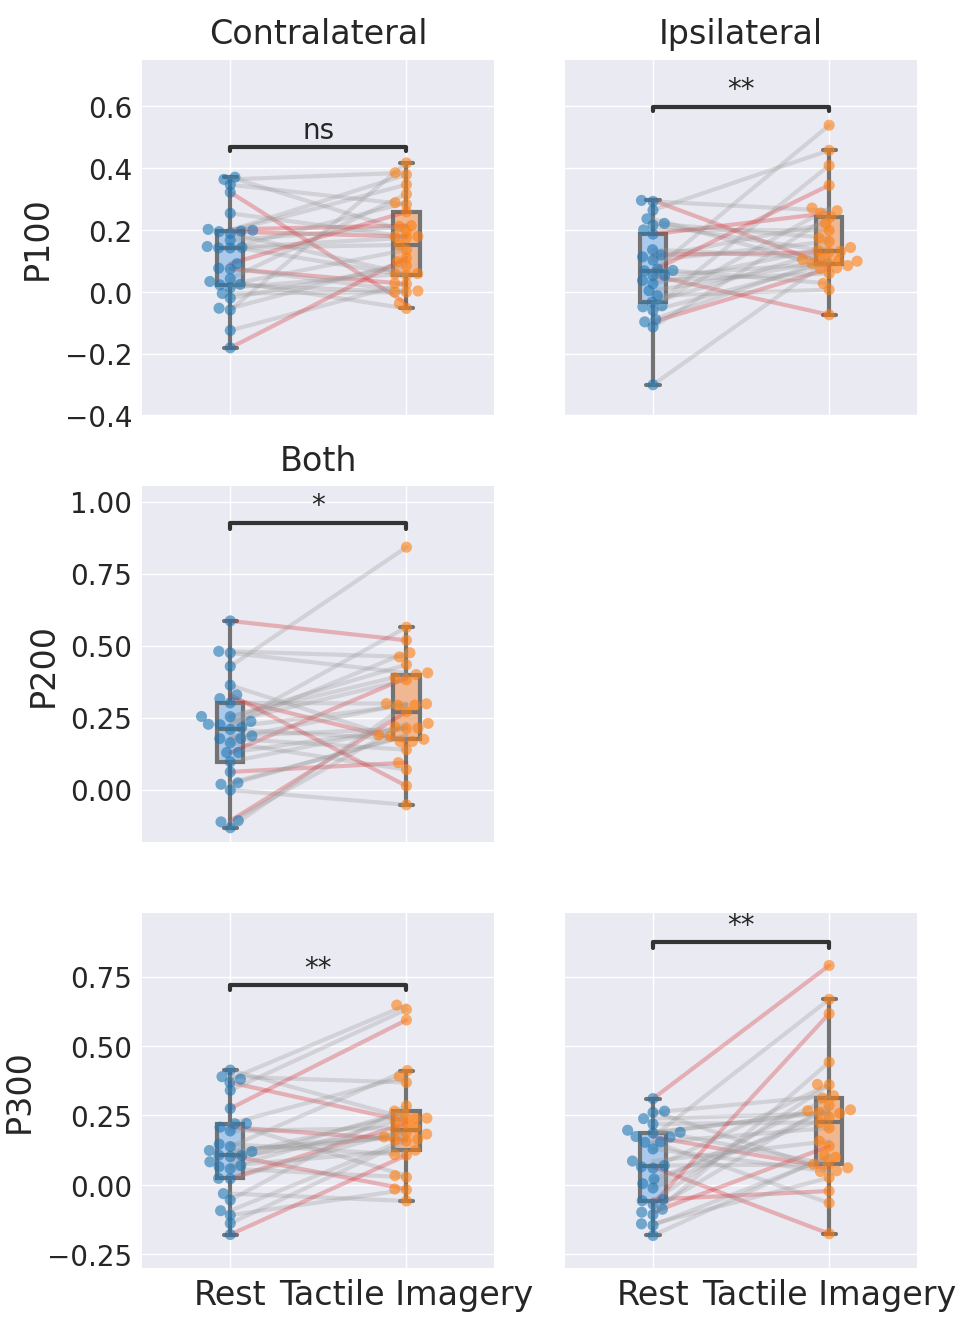

In [27]:
with plt.style.context(('seaborn-darkgrid')):

    cond = np.array(list(np.argwhere(mu_power_learning>0)[0]) + list(np.argwhere(mu_power_imagery>0)[:, 0])) # bad_imaginers
    not_cond = np.array([i for i in range(n_part) if i not in cond]) # good imaginers

    fig, axes = plt.subplots(nrows=3, ncols=2, dpi=200, figsize=(5, 8), sharex=True, sharey='row')
    f1 = 18
    f2 = 20

    box_pairs = [
        ('Rest', 'Imagery')
    ]

    peaks = [
        ['P100_left', 'P100_right'],
        ['P200_both'],
        ['P300_left', 'P300_right']
    ]

    palette = np.array(["#999999"]*len(np.unique(df.id)))
    palette[cond.astype(int)] = '#D62728'

    all_locs = [[es_p100_left, es_p100_right], [es_p200_left, es_p200_right], [es_p300_left, es_p300_right]]

    for i, ps in enumerate(peaks):
        for j, peak in enumerate(ps):
            sns.boxplot(data=df, x='condition', y=peak, showfliers=False, ax=axes[i][j], palette='pastel', width=0.15)
            g = sns.swarmplot(data=df, x='condition', y=peak, ax=axes[i][j], alpha=0.6, size=4)
            sns.lineplot(data=df, y=peak, x='condition', hue='id', sort=False, palette=sns.color_palette(palette),
                         estimator=None, legend=False, ax=axes[i][j], alpha=0.3)

            test_results = add_stat_annotation(g, data=df, x='condition', y=peak,
                                               box_pairs=box_pairs, comparisons_correction=None,
                                               test='t-test_paired', text_format='star',
                                               loc='inside', verbose=2)
            axes[i][j].set_xlabel('') 
            axes[i][j].set_ylabel('')
            axes[i][j].grid(color='white', linewidth=0.5)

    #         leg = axes[i][j].legend(loc=2)
    #         leg.set_title(', '.join([electrodes[i] for i in all_locs[i][j]]),prop={'size':8})

        axes[i][0].set_ylabel(peak[:4], fontsize=12)#, fontweight='bold')
        axes[i][0].sharey(axes[i][1])
        
        

    axes[0][0].set_ylim(-0.4, 0.75)
    axes[-1][0].set_ylim(-0.3, 0.98)

    # axes[1][1].set_ylabel('z-score', fontsize=12)

    axes[0][0].set_title('Contralateral')
    axes[0][1].set_title('Ipsilateral')

    axes[-1][0].set_xticklabels(['Rest', 'Tactile Imagery'], rotation=0, size=12) # , weight='bold'
    axes[-1][1].set_xticklabels(['Rest', 'Tactile Imagery'], rotation=0, size=12) # , weight='bold'

    # suptitle = plt.suptitle('Peak amplitudes\nWilcoxon test (paired samples)', fontsize=f2, fontweight='bold', y=1.03)

    axes[1][0].set_title('Both')
    axes[1][1].set_axis_off()

    plt.savefig('figs/erp_stats.jpg', bbox_inches='tight') # , bbox_extra_artists=[suptitle]

In [28]:
def get_li(x, y):
    return (x-y)/(x+y)

In [29]:
df_peaks_li = pd.DataFrame({
    'P100_rest':get_li(df[df.condition == 'Rest'].P100_right, df[df.condition == 'Rest'].P100_left),
    'P100_imagery':get_li(df[df.condition == 'Imagery'].P100_right, df[df.condition == 'Imagery'].P100_left),
    'P200_rest':get_li(df[df.condition == 'Rest'].P200_right, df[df.condition == 'Rest'].P200_left),
    'P200_imagery':get_li(df[df.condition == 'Imagery'].P200_right, df[df.condition == 'Imagery'].P200_left),
    'P300_rest':get_li(df[df.condition == 'Rest'].P300_right, df[df.condition == 'Rest'].P300_left),
    'P300_imagery':get_li(df[df.condition == 'Imagery'].P300_right, df[df.condition == 'Imagery'].P300_left),
})

df_peaks_li.head()

,P100_rest,P100_imagery,P200_rest,P200_imagery,P300_rest,P300_imagery
0,-0.586447,-2.061785,-0.539292,-0.259212,-1.334323,-1.214452
1,-2.986989,-0.409855,-1.445086,-0.208139,-0.092768,-0.450355
2,-0.948364,-0.210566,-0.223339,1.023673,0.292562,0.088892
3,0.234312,0.667097,0.120096,-0.006266,1.621747,-0.227420
4,0.170931,-0.183998,0.018279,-0.343411,-6.863999,-0.380132


In [30]:
print('Lateralization Indices (LI)\n')
for i in df_peaks_li.columns.values:
    print(i)
    get_stat(df_peaks_li[i])
    print()

Lateralization Indices (LI)

P100_rest
-0.11 [-0.76-0.32]

P100_imagery
0.14 [-0.26-0.58]

P200_rest
-0.17 [-0.31--0.01]

P200_imagery
-0.03 [-0.18-0.12]

P300_rest
-0.09 [-0.73-0.29]

P300_imagery
0.04 [-0.38-0.18]



In [31]:
print(stats.wilcoxon(df_peaks_li.P100_rest, df_peaks_li.P100_imagery))
print(stats.wilcoxon(df_peaks_li.P200_rest, df_peaks_li.P200_imagery))
print(stats.wilcoxon(df_peaks_li.P300_rest, df_peaks_li.P300_imagery))

WilcoxonResult(statistic=142.0, pvalue=0.10555979982018471)
WilcoxonResult(statistic=86.0, pvalue=0.0035108327865600586)
WilcoxonResult(statistic=163.0, pvalue=0.24702516570687294)
